# IVADO/MILA DEEP LEARNING SCHOOL
# 4th edition (Fall 2019)
# Tutorial : Recurrent neural networks (RNNs)
## Tutorial was adapted from this one (in French): 
https://github.com/mila-iqia/ecole_dl_mila_ivado/blob/master/tutoriaux/RNN/RNN_solutions.ipynb



## Authors

Francis Grégoire <francis.gregoire@mila.quebec>

Jeremy Pinto <jeremy.pinto@mila.quebec>

Mirko Bronzi <mirko.bronzi@mila.quebec>

Arsène Fansi Tchango <arsene.fansi.tchango@mila.quebec>

### Translation to English: 

Laurent Charlin <lcharlin@gmail.com>

## Preface

This tutorial introduces the fundamental concepts that underlie recurrent neural networks (RNN et LSTM) using two example tasks.

The first task builds and compares an LSTM model to an RNN model.

In the second task, we exploit the properties of an LSTM by developing a neural language model to generate text. Through this example, you will learn how to preprocess text data to efficiently train a neural language model.

---
# Initialization 

To ensure that this tutorial runs properly on the Colab environment, we must install a few libraries using the `pip` utility. 

To begin, ensure that you are "connected" to the notebook ( check for "✓ CONNECTED" at the top right of your window). Then execute the cell below by selecting it and clicking `shift`+`Enter`. You will see the version of the installed `PyTorch` package and whether or not a GPU is available on this runtime session.

In [1]:
import copy
import time
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

# Setting the seed to a fixed value can be helpful in reproducing results
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

print("PyTorch version: ", torch.__version__)
print("GPU available: {}".format(use_gpu))

PyTorch version:  1.1.0
GPU available: True


---
# Task 1: Adding numbers


## Objective

Our goal is to build a recurrent model capable of adding an arbitrary series of numbers. It is all in all a fairly simple task (any pocket calculator can trivially do it) yet it will demonstrate that this procedure can be learned from data. Further, we will use it to outline certain limitations of RNNs compared to LSTMs. It is also a good first task since it will be easy to generate data for it and train our models (both RNN and LSTM) on this data.



## Dataset

Our data is composed of $x$ a set of sequences of numbers of length $seq\_len$ each associated with a target $y$ the sum of each element in each $x$. In other words, the input to our model will be a vector $\mathbf x^{(i)} = \left[x_{1}^{i}, x_{2}^{i}, \dots, x_{T}^{i}\right]$ of length $seq\_len=T$ and a target $y^{(i)}$ given by:

\begin{align}  
y^{(i)}=\sum_{j=1}^{seq\_len}x^{(i)}_j,
\end{align}

where $j$ indexes time.

For example, for the input $\mathbf x^{(i)}$ with $seq\_len=4$, we have:

\begin{align}  
\mathbf x^{(i)} &= \left[ 4,-1,15,24\right], \, \mathbf x^{(i)} \in \mathbb R^{4}; \\ 
y^{(i)} &= 42, \, \mathrm y^{(i)} \in \mathbb R.
\end{align}

We will use our data to train both an RNN and an LSTM. Since the target is an unbounded integer, we will use a linear hidden layer (i.e., identity activation) to project the last recurrent state of the RNN/LSTM, $h^{(i)}_{T}$, as shown on the following figure:

![Texte alternatif…](https://github.com/mila-iqia/ivado-mila-dl-school-2019/blob/master/images/rnn_sum.png?raw=true)


### Generating our dataset

It will be useful to have a function that can generate random datasets of `n_samples` sequences each of length `seq_length`. To do so we will rely on the function [torch.randint()](https://pytorch.org/docs/stable/torch.html#torch.randint). The function `generate_data` takes as input the following arguments:
- **n_samples** (int): number of sequences to generate.
- **seq_len** (int): length of each sequence.
- **input_dim** (int, optional): dimension of the input data. Default: 1.
- **xmin** (float, optional): minimum possible value in the sequence. Default: -100.
- **xmax** (float, optional): maximum possible value in the sequence. Default: -100.

It returns a tuple of two elements corresponding respectively to:
- **X** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)): A tensor of shape $n\_samples \times seq\_len \times input\_dim$ representing a set of `n_samples` sequences, each of length `seq_len`. The elements of the sequences are of dimension `input_dim`, that is, they belong to ${\mathbb R}^{input\_dim}$.
- **Y** ([torch.FloatTensor](https://pytorch.org/docs/stable/tensors.html)): A tensor of shape $n\_samples \times  input\_dim$ representing the corresponding sum of the elements for each sequence in `X`.

In [0]:
def generate_data(n_samples, seq_len, input_dim=1, xmin=-100, xmax=100):
    """Generate tensors X and Y within the [xmin, xmax] interval.
    
    Args : 
      n_samples: int, number of sequences to generate
      seq_len: int, length of each sequence
      input_dim: int, dimension of the input data
      xmin: minimum possible value in the sequence
      xmax: maximum possible value in the sequence
    
    Returns: n_samples sequence of numbers X and associated targets Y in this
             format torch.Tensor where X.shape = (n_samples, seq_len, 1)
             and Y.shape = (n_samples, 1).
    """
    X = torch.randint(xmin, xmax+1, (n_samples, seq_len, input_dim))
    Y = X.sum(dim=1)
    
    return X, Y

The following piece of code shows an example of how to use the `generate_data` function. In this example, we are generating 1000 sequences of numbers $\in \mathbb R$ (i.e, `input_dim` is set to 1), each one of lenght 4.

In [3]:
n_samples = 1000
seq_len = 4
input_dim = 1
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
print("Tensor dimensions X = {}".format(X.shape))
print("where n_samples = {}, seq_len = {}, input_dim = {}".format(*X.shape))
print("data example: {}".format(X[0,:,0]))

Tensor dimensions X = torch.Size([1000, 4, 1])
where n_samples = 1000, seq_len = 4, input_dim = 1
data example: tensor([ 71,  40, -84,  81])


### Standardizing data

To help the training of our model we will first standardize the input data such that it has, overall, `mean` 0 and standard deviation (`stdev`) 1. To do so we simply calculate the mean and std of our data and then substract the former and divide by the latter. In addition, we will store these two values for later usage. This standardization often speeds up learning.

**Note**: since we generated our data from a uniform distribution, the standard deviation should be close to $\frac{(xmax-xmin)}{\sqrt{12}}$ while the mean should be close to $\frac{(xmax+xmin)}{2}$.

The following function performs such a standardization operation. It takes as input a tensor **X** (of shape $n\_samples \times seq\_len \times input\_dim$) we would like to standardize and returns a tuple of 4 elements corresponding respectively to:
- **Xs**: the standardized version of X, of shape $n\_samples \times seq\_len \times input\_dim$
- **Ys**: the new sum of the sequences of Xs, of shape $n\_samples \times input\_dim$
- **mean**: the mean of X, float.
- **stdev**: the stdandard deviation of X, float.

In [0]:
def standardize(X):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      Ys: torch.Tensor, the (new) sum of Xs.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()
    mean = torch.mean(X)
    std = torch.std(X)
    Xs = (X-mean) / std
    Ys = Xs.sum(dim=1)
    
    return Xs, Ys, mean, std


An example of how to use the above defined function is shown below. Here, after generating the data using the `generate_data` function, we use the `standardize` function to standardize it.

In [5]:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
example_before = X[0,:,0]
Xs, Ys, mean, std = standardize(X)
print("mean = {:.4f}, std = {:.4f}".format(mean, std))
print('example before standardization: {}'.format(X[0,:,0]),
      '\nexample after standardization: {}'.format(Xs[0,:,0])
)

mean = 0.5472, std = 58.2220
example before standardization: tensor([-55,  70, -84,  -9]) 
example after standardization: tensor([-0.9541,  1.1929, -1.4522, -0.1640])


## RNN implementation 

We will define our RNN using the following PyTorch class [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). For more details regarding the implementation of this class, we suggest this [tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net). Once initialized, it takes input data `X` of shape `(seq_len, batch_size, input_dim)` (recall that we will use `input_dim=1` for our task). As explained earlier, we then add a linear layer to transform the last hidden recurrent state to have the same dimensionality as `Y` which has size `(batch_size, input_dim)` (again `input_dim=1`). 

To define the architecture of our RNN, we will use this module [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn) followed by a linear layer [torch.nn.Linear()](https://pytorch.org/docs/stable/nn.html#linear). The following methods are to be completed:
<ul>
<li>The `__init__()` method to define the different layers of our model. </li>
<li>The `forward()` method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*).</li>
</ul>

**NB**: 

* It can be puzzling to obtain the last recurrent state of the last hidden layer of an RNN, $h_{T}^{N}$, where $T$ is the last timestep and $N$ is the last hidden layer. It can be obtained by indexing one of these tensors as follows: `output[-1, :, :]` or `h_n[-1]`.

* You must ensure that the dimensions of your input data `X` matches what is required by the RNN class [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn). 

  **Hint:** this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful.

### Exercise:

Complete this piece of code to implement the above described network using the [torch.nn.RNN()](https://pytorch.org/docs/stable/nn.html?highlight=rnn#rnn) class. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hiden_size**: the size of the hidden state of the RNN
- **n_layers**: the number of layers of the RNN.

In [0]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn = nn.RNN(input_dim,
                          hidden_size,
                          n_layers)
        
        self.linear = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        x = x.transpose(0, 1) 
        output, h_n = self.rnn(x)
        pred = self.linear(h_n[-1])
        return pred
    

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [7]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_rnn = model_rnn.to(device)

# save its initial weights
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_rnn(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])


## LSTM implementation

We will now implement an LSTM using this PyTorch class [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). Just like with the RNN, we will need to add a linear layer to transform the last recurrent state of our LSTM to have the same dimensions of our target `Y` which has size `(batch_size, input_dim)` (with `input_dim=1` as above). For additional information regarding the implementation of this class have look at this [tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net).

To define the architecture of our LSTM, the following methods are to be completed:
<ul>
    <li>The `__init__()` method to define the different layers of our model.</li>
<li>The `forward()` method method which uses the layers and the input variables and returns an output (this is effectively a *forward pass*). </li>
</ul>

**NB**: 

* It can be puzzling to obtain the last recurrent state of the last hidden layer of an RNN, $h_{T}^{N}$, where $T$ is the last timestep and $N$ is the last hidden layer. It can be obtained by indexing one of these tensor as follows: `output[-1, :, :]` or `h_n[-1]`.

* You must ensure that the dimensions of your input data `X` matches what is required by the LSTM class [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM). 
   
   **Hint**: this method [tensor.transpose()](https://pytorch.org/docs/stable/tensors.html?highlight=transpose#torch.Tensor.transpose) can be useful.


### Exercise:

Complete this piece of code to implement the above described network using the [torch.nn.LSTM()](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) class. The input arguments are the following:
- **input_dim**: the dimension of the input data
- **output_dim**: the dimension of the output data
- **hiden_size**: the size of the hidden state of the RNN
- **n_layers**: the number of layers of the RNN.

In [0]:
class LSTMLinear(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(LSTMLinear, self).__init__()
        self.LSTM = nn.LSTM(input_dim,
                            hidden_size,
                            n_layers)
        
        self.linear = nn.Linear(hidden_size, output_dim)
        
    def forward(self, x):
        # the input to an LSTM must be of size (seq_len, batch_size, input_dim)
        x = x.transpose(0, 1)
        output, (h_n, c_n) = self.LSTM(x)
        pred = self.linear(h_n[-1])
        
        return pred
    

Here is an example of how this class can be used to predict the values of the sequences in Xs.

In [9]:
n_samples = 50
seq_len = 4
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Data generation
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)
Xs, Ys, mean, std = standardize(X)

# Declaration of the LSTM model
model_lstm = LSTMLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_lstm = model_lstm.to(device)

# save its initial weights
init_lstm_weights = copy.deepcopy(model_lstm.state_dict())

# Transfer the data to the proper device
Xs = Xs.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_lstm(Xs)
print("Size of input data: {}".format(Xs.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)

Size of input data: torch.Size([50, 4, 1])
Size of predictions: torch.Size([50, 1])


## Splitting the data into train/validation/test

### Exercise

We will use PyTorch's DataLoader objects to efficiently manipulate our data. 

We will generate 20,000 sequences and use 80% of those for training, 10% for validation, and 10% for testing. We can use the following functions [torch.utils.data.TensorDataset()](https://pytorch.org/docs/stable/data.html) and [torch.utils.data.DataLoader()](https://pytorch.org/docs/stable/data.html) to prepare our Dataloader.

Use the following values: 

`seq_len = 18` 

`batch_size = 64`

`n_samples = 25000`

In [0]:
from torch.utils.data import DataLoader, TensorDataset

n_samples = 25000
seq_len = 18
batch_size = 64

# generate the data:
X, Y = generate_data(n_samples, seq_len, input_dim, -100, 100)

# and standardize it:
Xs, Ys, mean, std = standardize(X)

xtrain, ytrain = Xs[:round(0.8*n_samples)], Ys[:round(0.8*n_samples)]
xvalid, yvalid = Xs[round(0.8*n_samples):round(0.9*n_samples)], Ys[round(0.8*n_samples):round(0.9*n_samples)]
xtest, ytest = Xs[round(0.9*n_samples):], Ys[round(0.9*n_samples):]

# dataloader for the training dataset
train_loader = DataLoader(TensorDataset(xtrain, ytrain), batch_size, shuffle=True)

# do the dataloader for the validation dataset
valid_loader = DataLoader(TensorDataset(xvalid, yvalid), batch_size, shuffle=False)

# dataloader for the test dataset
test_loader = DataLoader(TensorDataset(xtest, ytest), batch_size, shuffle=False)

## Training the RNN-based model

Several cost functions and optimizers can be used from PyTorch. 

### Exercise: Defining the cost and the optimizer

Recall that a cost function  $J(\theta) = L(x, y, \theta)$ takes as input a prediction and the target and evaluates some distance (or discrepancy) between both.  For this example, we will use the mean squared error cost which is standard for regression problems (see [torch.nn.MSELoss()](https://pytorch.org/docs/stable/nn.html)):

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.


To optimize the parameters of our networks we will use the *stochastic gradient descent* (SGD) optimizer. It minimizes the cost function $J(\theta)$ parametrized by the networks' weights $\theta$ by updating them using the following update rule: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, where  $\alpha$ is the *learning rate*. The specificity of SGD is that it will calculate the gradient $\nabla$ using a single (or a small number of) example(s) instead of the full training data.

In PyTorch we will use <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> which is a SGD implementation. In this example, we will use a learning rate of 0.001.

Complete the following piece of code by defining the MSE criterion and the optimizer.

In [0]:
learning_rate = 0.001

# Define the Criterion
criterion = nn.MSELoss()

# Define the Optimizer
optimizer_rnn = optim.SGD(model_rnn.parameters(), lr=learning_rate)

### Exercise: Training the model

To train out model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*. We will use `n_epoch = 25`.

Complete the following piece of code with the instructions correponding to the related comments.

In [12]:
since = time.time()


train_loss_history = []
valid_loss_history = []

n_epoch = 25

model_rnn.load_state_dict(init_rnn_weights)

print("Start training")

for epoch in range(n_epoch):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_rnn.train()
    torch.set_grad_enabled(True)
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        x = x.to(device)
        y = y.to(device)

        # Zero the gradient buffer
        optimizer_rnn.zero_grad()
        
        # Perform the Forward operation
        outputs = model_rnn(x)
        
        # Calculate the loss using the criterion function
        loss = criterion(outputs, y)
        
        # Perform the Backward operation
        loss.backward()
        
        # Perform the Optimization step
        optimizer_rnn.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_rnn.eval()
    with torch.no_grad():
    
        # Iterate over valid data
        for x, y in valid_loader:  
        
            # Put tensors on device (GPU when available)
            x = x.to(device)
            y = y.to(device)
        
            # Perform the Forward operation
            outputs = model_rnn(x)
            
            # Calculate the loss using the criterion function
            loss = criterion(outputs, y)
        
            # Statistics
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)


    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Start training
Epoch  1 | Training loss = 17.77481 | Validation loss = 18.76997 
Epoch  2 | Training loss = 11.14676 | Validation loss = 5.02436 
Epoch  3 | Training loss = 4.47669 | Validation loss = 5.57182 
Epoch  4 | Training loss = 3.85912 | Validation loss = 2.94003 
Epoch  5 | Training loss = 2.67626 | Validation loss = 2.40018 
Epoch  6 | Training loss = 1.92790 | Validation loss = 1.01247 
Epoch  7 | Training loss = 1.70548 | Validation loss = 2.36304 
Epoch  8 | Training loss = 1.48389 | Validation loss = 0.78342 
Epoch  9 | Training loss = 1.40851 | Validation loss = 0.89388 
Epoch 10 | Training loss = 1.37219 | Validation loss = 0.75786 
Epoch 11 | Training loss = 1.23013 | Validation loss = 0.62933 
Epoch 12 | Training loss = 1.13151 | Validation loss = 2.46569 
Epoch 13 | Training loss = 1.11956 | Validation loss = 1.17553 
Epoch 14 | Training loss = 0.97094 | Validation loss = 1.75814 
Epoch 15 | Training loss = 0.88143 | Validation loss = 0.42881 
Epoch 16 | Training lo

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

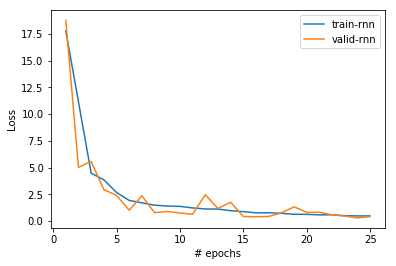

In [13]:
# Save history for later
rnn_train_loss_history = train_loss_history
rnn_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Training the LSTM-based model

(This cell is reproduced from the equivalent RNN one above, skip if you have read/understood that one.)

### Exercise: Defining the cost and the optimizer

Recall that a cost function  $J(\theta) = L(x, y, \theta)$ takes as input a prediction and the target and evaluates some distance (or discrepancy) between both.  For this example, we will use the mean squared error cost which is standard for regression problems (see [torch.nn.MSELoss()](https://pytorch.org/docs/stable/nn.html)):

$J(\cdot) = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_{i} - y_i)^{2}$.


To optimize the parameters of our networks we will use the *stochastic gradient descent* (SGD) optimizer. It minimizes the cost function $J(\theta)$ parametrized by the networks' weights $\theta$ by updating them using the following update rule: $\theta \leftarrow \theta - \alpha \nabla J(\theta)$, where  $\alpha$ is the *learning rate*. The specificity of SGD is that ti will calculate the gradient $\nabla$ using a single (or a small number of) example(s) instead of the full training data.

In PyTorch we will use <a href="http://pytorch.org/docs/master/optim.html#torch.optim.SGD">`torch.optim.SGD()`</a> which is a SGD implementation. In this example, we will use a learning rate of 0.01.

Complete the following piece of code by defining the MSE criterion and the optimizer.

In [0]:
learning_rate = 0.001

# define the Criterion
criterion = nn.MSELoss()

# define the optimizer
optimizer_lstm = optim.SGD(model_lstm.parameters(), lr=learning_rate)

### Exercise: Training the model

To train out model, we will use our `train_loader` object to iterate over our entire training sets *n_epoch* times. 
To measure progress we will store the validation cost at the end of each training *epoch*. We will use `n_epoch = 25`.

Complete the following piece of code with the instructions correponding to the related comments.

In [15]:
since = time.time()


train_loss_history = []
valid_loss_history = []

num_epochs = 25

model_lstm.load_state_dict(init_lstm_weights)

print("# Start training #")

for epoch in range(num_epochs):
    
    train_loss = 0
    train_n_iter = 0
    
    # Set model to train mode
    model_lstm.train()
    torch.set_grad_enabled(True)
    
    # Iterate over train data
    for x, y in train_loader:  

        
        # Put tensors on device (GPU when available)
        x = x.to(device)
        y = y.to(device)

        # Zero the gradient buffer
        optimizer_lstm.zero_grad()
        
        # Perform the Forward operation
        outputs = model_lstm(x)
        
        # Calculate the loss using the criterion function
        loss = criterion(outputs, y)
        
        # Perform the Backward operation
        loss.backward()
        
        # Perform the Optimization step
        optimizer_lstm.step()
        
        # Statistics
        train_loss += loss.item()
        train_n_iter += 1
    
    valid_loss = 0
    valid_n_iter = 0
    
    # Set model to evaluate mode
    model_lstm.eval()
    with torch.no_grad():
    
        # Iterate over valid data
        for x, y in valid_loader:  
        
            # Put tensors on device (GPU when available)
            x = x.to(device)
            y = y.to(device)
        
            # Perform the Forward operation
            outputs = model_lstm(x)
            
            # Calculate the loss using the criterion function
            loss = criterion(outputs, y)
        
            # Statistics
            valid_loss += loss.item()
            valid_n_iter += 1
    
    train_loss_history.append(train_loss / train_n_iter)
    valid_loss_history.append(valid_loss / valid_n_iter)
    
    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
          .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

time_elapsed = time.time() - since

print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

# Start training #
Epoch  1 | Training loss = 17.95037 | Validation loss = 19.26374 
Epoch  2 | Training loss = 17.89081 | Validation loss = 19.23299 
Epoch  3 | Training loss = 17.85562 | Validation loss = 19.18587 
Epoch  4 | Training loss = 17.79454 | Validation loss = 19.10257 
Epoch  5 | Training loss = 17.67133 | Validation loss = 18.91971 
Epoch  6 | Training loss = 17.37354 | Validation loss = 18.31602 
Epoch  7 | Training loss = 14.79688 | Validation loss = 10.11912 
Epoch  8 | Training loss = 6.09395 | Validation loss = 4.69926 
Epoch  9 | Training loss = 3.12278 | Validation loss = 2.58178 
Epoch 10 | Training loss = 1.65869 | Validation loss = 1.50050 
Epoch 11 | Training loss = 1.05347 | Validation loss = 1.09437 
Epoch 12 | Training loss = 0.78372 | Validation loss = 0.81593 
Epoch 13 | Training loss = 0.62839 | Validation loss = 0.70063 
Epoch 14 | Training loss = 0.52416 | Validation loss = 0.56875 
Epoch 15 | Training loss = 0.46032 | Validation loss = 0.49899 
Epoch 1

### Visualizing training curves 

Visualize the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

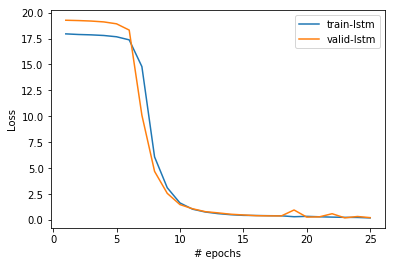

In [16]:
# Save history for later
lstm_train_loss_history = train_loss_history
lstm_valid_loss_history = valid_loss_history

# Plot training and validation curve
xaxis = range(1, num_epochs + 1)
plt.plot(xaxis, lstm_train_loss_history, label='train-lstm')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Analyzing the results

We will now compare the RNN and the LSTM using their performance on train/validation and test sets.

### Exercise: Comparing training curves


Compare the training curves using a graph of the cost function vs. epochs for both the training and the validation data.

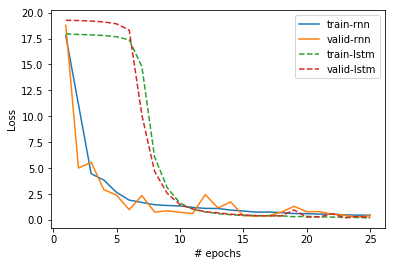

In [17]:
# Plot training and validation curve
xaxis = range(1, num_epochs + 1)

plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.plot(xaxis, lstm_train_loss_history, label='train-lstm', linestyle='--')
plt.plot(xaxis, lstm_valid_loss_history, label='valid-lstm', linestyle='--')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Questions**

1. Which network works best according to validation? Why is that? 
2. Assume you want to increase the gap between the RNN and LSTM performances. How would you modify the data?


**Possible answers**
1. Being a simple toy problem, both the architectures converge to similar results. Still, LSTM should achieve slightly better performances. On the other hand, LSTM is slower to converge (given the architecture is more complex).
2. The gap between LSTM and RNN should increase if we increase the length of the sequence. With long sequences, the ability of LSTM to better capture long-term dependencies should make a difference.



### Exercise: Evaluating test error

Complete the following piece of code in order to evaluate and print the mean squared error on the test set for both models.

In [18]:
# Put sequence data on device (GPU when available)
xtest = xtest.to(device)

# Put target data on device (GPU when available)
ytest = ytest.to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(xtest)

# Predict the value of the sequence data using the LSTM-based model
ypred_lstm = model_lstm(xtest)

# Compute the loss of the RNN-based model using the criterion function
loss_test_rnn = criterion(ypred_rnn, ytest)

# Compute the loss of the LSTM-based model using the criterion function
loss_test_lstm = criterion(ypred_lstm, ytest)


print("The RNN's test mean squared error is %2.3f" % float(loss_test_rnn))
print("The LSTM's test mean squared error is %2.3f" % float(loss_test_lstm))

The RNN's test mean squared error is 0.404
The LSTM's test mean squared error is 0.192


### Exercise: Further exploring the results

To gain insights into our models we will inspect their outputs (i.e., their predictions before calculating the cost). To help us we will define a `print_sequence()` function. 

This function takes as input the tensors X and Y, samples a particular entry (sequence), prints the entry and prints the absolute difference between the true Y and the predicted Y.

Recall that we have standardized our examples. For these visualizations we wish to use the original data pre-standardization. To do so, we use `mean` + `std` such that $xtest\_unstd = xtest*std + mean$ et $ytest\_unstd = ytest*std+seq\_len*mean$.


In [0]:
def print_sequence(X, Y, idx=0):
    """Print ground truth sum and predicted values.
    Args:
      X: torch.Tensor.
      Y: torch.Tensor.
      idx: index of the sequence (entry) to use.
    """
    x = X[idx].numpy()
    y = Y[idx].numpy()
    for i, xi in enumerate(x):
        if i==0:
            string = str(xi[0]) 
        else:
            string += " + " + str(xi[0])
            
    print("Sequence: ", string)
    print("Prediction: ", str(y[0]))
    print("Ground truth value: ", str(np.sum(x)))
    diff = abs(np.sum(x)-y[0])
    print("Absolute error between X[{a}] et Y[{a}]: {b}".format(a=idx, b=diff))

Complete the following piece of code by unstandardizing `xtest` and `ypred_rnn` values.

In [20]:
xtest = xtest.cpu()
ypred_rnn = ypred_rnn.cpu()

# Unstandardize  xtest
xtest_unstd = xtest*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + seq_len*mean

idx = np.random.randint(len(ytest))


print("")
print("Example RNN:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)



xtest = xtest.cpu()
ypred_lstm = ypred_lstm.cpu()

xtest_unstd = xtest*std + mean
ypred_unstd = ypred_lstm*std + seq_len*mean

print("")
print("Example LSTM:")
print("")

print_sequence(xtest_unstd.detach(), ypred_unstd.detach(), idx=idx)


Example RNN:

Sequence:  -31.0 + -12.0 + -74.0 + -82.0 + 22.0 + -37.0 + 8.0 + -58.0 + -37.0 + 31.0 + 0.0 + 13.0 + 64.0 + -19.0 + -54.0 + 3.9999998 + -31.0 + 70.0
Prediction:  -242.69835
Ground truth value:  -223.0
Absolute error between X[231] et Y[231]: 19.698348999023438

Example LSTM:

Sequence:  -31.0 + -12.0 + -74.0 + -82.0 + 22.0 + -37.0 + 8.0 + -58.0 + -37.0 + 31.0 + 0.0 + 13.0 + 64.0 + -19.0 + -54.0 + 3.9999998 + -31.0 + 70.0
Prediction:  -206.77145
Ground truth value:  -223.0
Absolute error between X[231] et Y[231]: 16.228546142578125


** Bonus exercise**

* Redo the above analysis but instead of summing the input values try other operations (e.g., product)
* Compare the performance of the RNN and the LSTM for sequences of different length (i.e., change `seq_len`)

---
# Task 2: Neural language model


## Objective

The objective of the second part of the tutorial is to learn about text generation using recurrent neural networks. In particular, we will train a recurrent neural network using a small amount of textual data written by [Shakespeare]https://en.wikipedia.org/wiki/William_Shakespeare). Once this model is trained, we will use it to generate new text in the style of Shakespeare.

**Note** that people often use the term RNN even when training an LSTM. RNN has become the generic term regardless of the type (in addition to LSTMs, there are other variants that are commonly used such as [Gated Recurrent Units (GRUs)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)).

The model we will use is a bit more complex than the one for task 1. Contrary to the previous section, all code is provided (i.e., there are no exercises to complete). We suggest you go through all of the code to ensure that you understand both its logic as it relates to text processing but also how to design and train an RNN for text generation. The code could be relatively easily adapted to other tasks that you may care about. 

Further, this notebook also contains some of the data pre-processing steps, in particular the ones that take our dataset and arranges it such that it can be used to train a neural language model based on LSTMs.  

Happy generation!

## A bit more context to understand language modelling



A sequence of words $\mathbf{s}$ can be represented as a sequence of $N$ discrete symbols (or lexical tokens) such that $\mathbf{s} = (w_{1}, \dots, w_{N})$, where $w_{t}$ is a word or a punctation mark. Each symbol can be represented by an integer corresponding to its index in the vocabulary $V$. $V$ contains all symbols for a particular task (the vocabulary is usually built from the dataset we use for a task). The objective of a language model is to estimate the (joint) probability of a sequence $p(\mathbf{s}) = p(w_{1}, \dots, w_{N})$, which can be decomposed as a product of conditional probabilities such that:

\begin{equation}
  p(\mathbf{s}) = \prod^{N}_{t=1} p(w_{t} | w_{1}, \dots, w_{t-1}).
\end{equation}
(this is also known as the chain rule in probability theory)

This is important for modelling. In particular, instead of modelling the joint distribution directly, we can "simply" model each conditional. That is we can model the probability of the next word given all previous words ($p(w_{t} | w_{<t})$). Language models do just that and are widely used across numerous applications (including in automatic translation, speech recognition, and information retrieval). Note that this can be understood as a multi-class classification problem where the classes corresponds to the different words.

However, modelling each conditional is not easy. Instead we perform an approximation which makes the problem easier. The intuition behind the approximation is that instead of conditioning of the whole history we condition on a smaller history ($w_{t-1}, w_{t-2}, \ldots, w_{t-n}$) to predict the next word ($w_{t}$). This is also known as a $n$-order Markov assumption. Mathematically it is:
\begin{equation}
  p(w_{t} | w_{1}, \dots, w_{t-1}) \approx p(w_{t} | w_{t-n}, \dots, w_{t-1}).
\end{equation}

In the next paragraph we explain how to model the above conditionals using a recurrent neural network. 



### Modeling using RNNs

The architecture of the neural language model we use is an LSTM networks which will learn at each timestep a conditional distribution of the next word using a number of previous words.
To train its parameters, we first need to set the maximum number $n$ of previous words to consider (`seq_len` in the code)--this is the effective size of your history--for training $p(w_{t} | w_{t-n}, \dots, w_{t-1})$. The input to the LSTM at each time step is: 
- the $t^{th}$ word $w_t$ encoded using its *word embedding* (see below); 
- the recurrent state ($\mathbf{h}_{t-1}$); and 
- the state of the memory at the previous timestep ($\mathbf{c}_{t-1}$).

The output of the LSTM at each step is the next word $w_{t+1}$. That is, we train the LSTM to predict the next word at each step (in details the LSTM will actually predict the probability of that next word). This also implies that once this model is trained, we will be able to use it to generate text (we will simply pick the word with the highest probability and feed it as the input to the next step). This type of model is commonly known as an *LSTM-based neural network model*. Its architecture is shown below:

![alt-text](https://github.com/nextai-mtl/tech-2019/blob/master/images/autoregressive_english.png?raw=true)


To compute the probability over all next words, we simply use a *softmax* activation function. The softmax function returns a normalized $|V|$-dimensional vector, where each entry corresponds to a single word in the vocabulary. Each entry can be understood as the "probability" that the next word should the word at this index.



### Word Embeddings


The main question that remains is how exactly to encode the words at each timestep. 
Since the input data to a neural network must be encodable in a matrix, each symbol (word) $w_t$ in the vocabulary can be represented as a *one-hot* vector $\mathbf{x}_i$ which is a vector of zeros with a single 1 at the position of the index of this word in the vocabulary. Thus, these *one-hot* vectors belong to $ \mathbb R^{|V|}$ where $|V|$ is the size of the vocabulary, that is, the number of words in the vocabulary. These one-hot vectors are multiplied by a weight matrix $\mathbf{E} \in \mathbb R^{|V| \times d_{e}}$. This matrix is learned and is known as the *embedding matrix*, $\mathbf{E} \in \mathbb R^{|V| \times d_{e}}$, it effectively encodes words in a continuous representation: $\mathbf{w}_{t} \in \mathbb R^{d_{e}}$.

Using word embeddings, a sequence of words can therefore be represented a sequence of size-$N$ vectors $\mathbf{s} = (\mathbf{w}_{1}, \dots, \mathbf{w}_{N})$. Each line $i$ of this matrix $\mathbf{E}$ is a representation in $d_{e}$ dimensions of the $i$'th word in the vocabulary $V$. As we said above, these representations are often called *word embeddings*. When they are learned from a large enough dataset, they can represent semantic similarity. [For more information regarding word embeddings](http://ruder.io/word-embeddings-1/index.html).

## Utility functions for processing text and data structuring

To train our neural language model, we will use a dataset (corpus) of the works of Shakespeare (we used a subset from this link [https://norvig.com/ngrams/] which was cleaned, tokenized and standardized) available in the file `shakespeare_top20K.txt`.

To obtain reasonable results in practice we should train a language model using a very-large quantity of text. In this tutorial, we will use a relatively small corpus of 20000 sentences, 159884 tokens, and a vocabulary of 12354 tokens. A token is a lexical unit separated by a whitespace on each side in the text. In our case, a token is a word, a number or a punctuation mark. The vocabulary is the set of all tokens in a corpus. (Of course, our code generalizes to larger datasets.)

In [21]:
# Clone the git repo to obtain the data
!git clone https://github.com/nextai-mtl/tech-2019.git

Cloning into 'tech-2019'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 74 (delta 35), reused 52 (delta 21), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [0]:
START_VOCAB = ["_UNK"]
UNK_ID = 0
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The function `create_vocabulary` takes as input:
- **corpus_path**: path to a corpus data
- **vocab_path**: the path where a vocabulary from the provided corpus will be created
- **max_vocab_size**: the maximum number of words of the vocabulary

It creates a vocabulary composing of at most `max_vocab_size` of the frequent tokens within the corpus data. This vocabulary is saved under the `vocab_path` file.

In [0]:
def create_vocabulary(corpus_path, vocab_path, max_vocab_size=1e5):
    """Create and save the vocabulary of a corpus."""
    vocab = {}
    with open(corpus_path, "r", encoding="utf-8") as f:
        for line in f:
            tokens = line.strip().split()
            for token in tokens:
                if token in vocab:
                    vocab[token] += 1
                else:
                    vocab[token] = 1
    vocab_list = START_VOCAB + sorted(vocab, key=vocab.get, reverse=True)
    if len(vocab_list) > max_vocab_size:
        vocab_list = vocab_list[:max_vocab_size]
    with open(vocab_path, "w", encoding="utf-8") as f:
        for token in vocab_list:
              f.write(token + "\n")

The function `initialize_vocabulary` takes as input:
- **vocab_path**: the path to the file containing the vocabulary

It returns a tuple of two elements corresponding respectively to:
- **vocab**: a dictionnary `Token:Index` associating an index to each token in the vocabulary
- **rev_vocab**: a list of the (unique) tokens in the vocabulay associating each index to a token such that $vocab [rev\_vocab[i]] = i$.


In [0]:
def initialize_vocabulary(vocab_path):
    """Initialize the vocabulary."""
    if os.path.exists(vocab_path):
        with open(vocab_path, "r", encoding="utf-8") as f:
            rev_vocab = [line.strip() for line in f.readlines()]
        vocab = dict([(w, i) for (i, w) in enumerate(rev_vocab)])
        return vocab, rev_vocab
    else:
        raise ValueError("Vocabulary file {} not found.".format(vocab_path))

The function `read_corpus` takes as input:
- **corpus_path**: path to a corpus data

It returns the corpus data as a list of tokens.

In [0]:
def read_corpus(corpus_path):
    """Read and convert a corpus in a list of tokens."""
    with open(corpus_path, "r", encoding="utf-8") as f:
        corpus = f.read().split()
    return corpus

The function `corpus_to_token_ids` takes as input:
- **corpus**: the corpus as a list of tokens
- **vocab**: the vocabulary as a distionnary of the form `token:index`.

It returns a list of token-ids corresponding to the list of tokens as defined by the corpus.

In [0]:
def corpus_to_token_ids(corpus, vocab):
    """Convert a corpus in token-ids."""
    token_ids = [vocab.get(token, UNK_ID) for token in corpus]
    return token_ids

The function `batch_data` takes as input:
- **data**: list of token_ids
- **batch_size**: the batch size

It returns a structured version of the data in `batch_size` continuous sequences. The returned data has a shape `N* x batch_size` where `N* = int(len(data) / batch_size)`

In [0]:
def batch_data(data, batch_size):
    """Structure the data in bath_size continuous sequences."""
    
    n_batch = len(data) // batch_size
    data = np.array(data[:n_batch*batch_size])
    data = data.reshape(batch_size, -1).T
    return data


The function `detach_hidden` takes as input:
- **hidden**: hidden state of an RNN

It transforms the data from this hidden state into a new Tensor with same values but where the computational history are lost.

In [0]:
def detach_hidden(hidden):
    """Transform the data from the hidden states of the LSTM
       into a new Tensor with require_grad=False."""
    return tuple(h.detach() for h in hidden)

Here is the piece of code where the corpus data are read, the vocabulary is created and the corpus data is structured in continuous sequences of `batch_size` for training purposes.

In [29]:
# Create and initialize the vocabulary
corpus_path = "tech-2019/data/shakespeare_top20K.txt"
vocab_path = "vocab.txt"

create_vocabulary(corpus_path, vocab_path)
vocab, rev_vocab = initialize_vocabulary(vocab_path)

# Read the training corpus
corpus = read_corpus(corpus_path)
token_ids = corpus_to_token_ids(corpus, vocab)

# Structure the corpus in continuous sequences of batch_size for training
batch_size = 10
data = batch_data(token_ids, batch_size)
data = torch.LongTensor(data).to(DEVICE)

print("Number of tokens in the corpus: {}"
      .format(len(corpus)), end="\n\n")
print("Size of vocabulary: {}"
      .format(len(vocab)), end="\n\n")
print("Top 20 most frequent tokens in the corpus: \n{}"
      .format(rev_vocab[1:21]), end="\n\n")
print("First sentence in the corpus in text format:\n{}"
      .format(" ".join(corpus[:31])), end="\n\n")
print("First sentence in the corpus in token-id format:\n{}"
      .format(token_ids[:31]), end="\n\n")
print("Test conversion from token-ids to text using rev_vocab:\n{}"
      .format(" ".join([rev_vocab[i] for i in token_ids[:31]])), end="\n\n")
print("Structure the training data (note that the first sentence "
      "is in the first colon):\n{}".format(data[:20]))

Number of tokens in the corpus: 159884

Size of vocabulary: 12354

Top 20 most frequent tokens in the corpus: 
[',', '.', 'the', 'I', ';', 'and', 'to', 'of', 'you', 'a', ':', 'in', '?', 'my', 'is', 'that', '!', 'not', 'it', 'me']

First sentence in the corpus in text format:
A MIDSUMMER-NIGHT'S DREAM Now , fair Hippolyta , our nuptial hour Draws on apace : four happy days bring in Another moon ; but O ! methinks how slow This old

First sentence in the corpus in token-id format:
[70, 5876, 5877, 194, 1, 143, 1948, 1, 58, 1425, 319, 4108, 46, 1949, 11, 607, 778, 608, 275, 12, 1950, 415, 5, 35, 62, 17, 1042, 119, 1115, 114, 173]

Test conversion from token-ids to text using rev_vocab:
A MIDSUMMER-NIGHT'S DREAM Now , fair Hippolyta , our nuptial hour Draws on apace : four happy days bring in Another moon ; but O ! methinks how slow This old

Structure the training data (note that the first sentence is in the first colon):
tensor([[   70,  3426,  1967,    31,    51,     1,  4276,     4,   

In the following block, we are splitting the data into training and validation datasets and we create the corresponding dataloaders. We use $10\%$ of the data for the validation set.

In [30]:
# Split ensembles training/validation and create DataLoaders
X = data[:-1]
Y = data[1:]

n_valid = round(data.size(0) * 0.1)
train_set = TensorDataset(X[:(data.size(0)-n_valid)], Y[:(data.size(0)-n_valid)])
valid_set = TensorDataset(X[-n_valid:], Y[-n_valid:])

seq_len = 40
train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size=seq_len, shuffle=False)

print("Training set: {} sequences of length {} and {} minibatches"
      .format(len(train_set), seq_len, len(train_loader)))
print("Validation set: {} sequences of length {} and {} minibatches"
      .format(len(valid_set), seq_len, len(valid_loader)))

Training set: 14389 sequences of length 40 and 360 minibatches
Validation set: 1599 sequences of length 40 and 40 minibatches


## Implementing the model

Below you will find the code of an *LSTM-based neural language model* as described in the **A bit more context to understand language modelling** Section.

At each timestep, the input variables of the LSTM are:
<ol>
    <li> a minibatch of sequences of token-ids (i.e., sequences of indices where each index represents the position of a token in the vocabulary);</li>
    <li> tuples $(\mathbf{h}_{0}, \mathbf{c}_{0})$ corresponding to recurrent states and memory states  $(\mathbf{h}_{T}, \mathbf{c}_{T})$ from the previous minibatch  (except for the first minibatch where we simply initialize these variables to 0.0 with the `init_hidden()` function).
</ol>

Each sequence of token-ids is transformed in sequences of *word embeddings* by indexing the *word embeddings* created by the class [torch.nn.Embedding()](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) which is a matrix of parameters of dimension $|V| \times d_{e}$, where $|V|$ is the vocabulary size (`vocab_size`) and $d_{e}$ is the dimension of a *word embedding* (`embedding_size`).

We will also apply dropout on the input *word embeddings* as well as on the output layer to provide regularization.

In [0]:
class LanguageModel(nn.Module):
    """LSTM based language neural model"""
    
    def __init__(self, vocab_size, input_size, hidden_size, n_layers=1, dropout=0.5):
        """
        Args:
          vocab_size: size of the vocabulary.
          input_size: size of the word embeddings.
          hidden_size: size of the hiden states of the LSTM.
          n_layers: number of layers of the LSTM (default: 1).
          dropout: if non-zero, uses a layer of dropout at the input at at the output of 
                    the LSTM introduit une couche dropout à l'entrée et à la sortie,
                    where the input sets the value of the dropout (default: 0.5).
        """        
        super(LanguageModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embeddings = nn.Embedding(vocab_size, input_size)
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            n_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.init_weights()

    def forward(self, input, hidden):
        embeddings = self.dropout(self.embeddings(input))
        output, hidden = self.lstm(embeddings, hidden)
        output = self.dropout(output)
        result = self.linear(output.view(output.size(0)*output.size(1), output.size(2)))
        return result.view(output.size(0), output.size(1), result.size(1)), hidden

    def init_weights(self):
        init.uniform_(self.embeddings.weight, -0.1, 0.1)
        init.xavier_uniform_(self.linear.weight, init.calculate_gain("linear"))
        init.constant_(self.linear.bias, 0)
        
    def init_hidden(self, batch_size):
        """Initialize the values of the hidden state and the LSTM cell to zero.
        Args:
          batch_size: size of a mini-batch at one time-step
          
        Returns:
          hidden: hidden state h_t and the cell c_t à t=0 initialized to 0, 
                  ((n_layers, batch_size, hidden_size),
                   (n_layers, batch_size, hidden_size)).
        """
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE),
                  torch.zeros(self.n_layers, batch_size, self.hidden_size, device=DEVICE))
        return hidden

## Training the model

The training procedure is very similar to the procedure used in Task 1. The key elements that differ are: 

* We use dropout on the input *word embeddings* as well as on the output layer of the LSTM. The small size of our data makes regularization important. In particular, for language models based on recurrent neural networks, we suggest using a fairly large droput value.
* We change the learning rate through training. We begin with a fairly high one (see `learning_rate`) and divide it by 10 as a function of the validation error at the end of each *epoch*. In particular we use this class:  [torch.optim.lr_scheduler.ReduceLROnPlateau()](https://pytorch.org/docs/stable/optim.html?highlight=plateau#torch.optim.lr_scheduler.ReduceLROnPlateau).
* To mitigate the problem of *exploding gradient* we use a *gradient-clipping* approach and normalize the norm of the gradient using this function [torch.nn.utils.clip_grad_norm_()](https://pytorch.org/docs/stable/nn.html?highlight=clip#torch.nn.utils.clip_grad_norm_).
* We initialize to 0.0 the values of the tuple containing the recurrent state and the hidden memory state $(\mathbf{h}_{0}, \mathbf{c}_{0})$ using the `init_hidden()` function. We do this only once at the beginning of each *epoch* and we propagate the new values of hidden through all training minibatches. In other words, the data has beeen structured using the `batch_data()` function such that we can initialize `hidden` $(\mathbf{h}_{0}, \mathbf{c}_{0})$ of each sequence of minibatch using $(\mathbf{h}_{T}, \mathbf{c}_{T})$ of the previous minibatch. Using this method implies that we cannot shuffle the order of the sequences at each training *epoch* (i.e., `train_loader = DataLoader(train_set, batch_size=seq_len, shuffle=False)`).
* Our cost function is the cross-entropy [torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/nn.html?highlight=crossentropy#torch.nn.CrossEntropyLoss) which is standard for multi-class classification problems.
* We will use *[perplexity](https://en.wikipedia.org/wiki/Perplexity)* as a way to measure the quality of our model. The intuition is that a good model should not be perplex when evaluating new data. 

In [32]:
# Construct the model
vocab_size = len(vocab)
embedding_size = 300
hidden_size = 400
n_layers = 1
dropout = 0.65
model = LanguageModel(vocab_size, embedding_size, hidden_size, n_layers, dropout).to(DEVICE)
print("Number of parameters in the model:", sum(param.nelement() for param in model.parameters()))

# Cost and optimization functions
learning_rate = 10
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)

# Training the model
n_epochs = 20
max_grad_norm = 1

print("Training the model for {} epochs of {} minibatches".format(n_epochs, len(train_loader)))
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
    hidden = model.init_hidden(batch_size)
    train_loss = 0
    valid_loss = 0
    for x, y in train_loader:
        # Separate the hidden nodes from the computational graph
        hidden = detach_hidden(hidden)
        
        # Reinitialize the gradient
        optimizer.zero_grad()
                
        # Forward pass
        y_pred, hidden = model(x, hidden)
        
        # Calculate the loss
        loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
        
        # Calculate the gradient
        loss.backward()
        
        # Normalise the gradient to prevent gradient exploding
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        # Update model parameters
        optimizer.step()        
        
        # Accumulate total loss
        train_loss += len(x) * loss.item()
    
    # Eval the model using the validation set
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(batch_size)
        for x, y in valid_loader:
            y_pred, hidden = model(x, hidden)
            loss = loss_fun(y_pred.view(-1, vocab_size), y.view(-1))
            valid_loss += len(x) * loss.item()
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    scheduler.step(valid_loss)

    print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} | Perplexity = {:.2f}"
          .format(epoch+1, train_loss, valid_loss, np.exp(valid_loss)))
print("Congratulations! You have now trained a neural language model!")

Number of parameters in the model: 9783354
Training the model for 20 epochs of 360 minibatches
Epoch  1 | Training loss = 6.75152 | Validation loss = 5.95324 | Perplexity = 385.00
Epoch  2 | Training loss = 5.99870 | Validation loss = 5.73263 | Perplexity = 308.78
Epoch  3 | Training loss = 5.78420 | Validation loss = 5.59909 | Perplexity = 270.18
Epoch  4 | Training loss = 5.65122 | Validation loss = 5.51186 | Perplexity = 247.61
Epoch  5 | Training loss = 5.54787 | Validation loss = 5.46572 | Perplexity = 236.45
Epoch  6 | Training loss = 5.46405 | Validation loss = 5.42848 | Perplexity = 227.80
Epoch  7 | Training loss = 5.38856 | Validation loss = 5.39275 | Perplexity = 219.81
Epoch  8 | Training loss = 5.32292 | Validation loss = 5.38218 | Perplexity = 217.50
Epoch  9 | Training loss = 5.26190 | Validation loss = 5.37339 | Perplexity = 215.59
Epoch 10 | Training loss = 5.20315 | Validation loss = 5.36897 | Perplexity = 214.64
Epoch 11 | Training loss = 5.15531 | Validation loss = 

## Text generation

Now that we have trained a language model, we can use it to generate text as Shakespeare! 
To do so, we will randomly select the first word (i.e., a token in a vocabulary) and use that as the input token at timestep one. We will then use the output token at the first timestep as the input token at the second timestep and son on. In total we will generate `n_words`. The `smoothing` variable allows one to obtain change the diversity of the generated text. A higher value generate more diverse but often lower quality text.

In [33]:
# Generating sequences of words
model.eval()
x = torch.randint(0, vocab_size, (1, 1), dtype=torch.long, device=DEVICE)
words = [rev_vocab[x]]
n_words = 300
smoothing = 0.5
with torch.no_grad(): 
    hidden = model.init_hidden(1)
    for i in range(n_words-1):
        output, hidden = model(x, hidden)
        weights = output.squeeze().div(smoothing).exp()
        word_idx = torch.multinomial(weights, 1)
        x.fill_(word_idx.squeeze())
        word = rev_vocab[word_idx]
        words.append(word)
        if (i+1) % 15 == 0:
            words.append("\n")
print(" ".join(words))

O'erbears her , and not the other . If she be , I will not take 
 him to a man . For the rest of my heart , I have my 
 mind , and to my father . He hath a kinsman for my father , 
 and yet my lord . I will not know thee . I prithee , I 
 will not say . I am not so . I am not so ; and 
 I will not go with him . I have rather given him , and so 
 I am a man . But , if I have a woman by the Count 
 Rousillon , it is I did . What is the matter ? If they are 
 , I pray you , sir . I will do it with it . I 
 am not glad to speak on him . I know her , by my faith 
 , And make me but to the court . O ! what shall he be 
 a man ? Ay , sir , to the duke . I am going to 
 the duke . I have a great deal of his own command , I am 
 not so . How now , my lord ! the matter is not enough to 
 do . I am sure I will think you , and he is not to 
 be a very good friend , I will not have a good husband . I 
 do , sir , the very good soldier . You are well glad to be 
 sure , as I had a bawd , and the oth

What do you think of this generated text? What is remarkable is that many short sequences of words seem plausible. Longer phrases, however, usually do not make much sense. 

We note that both commas `,` and periods `.` appear very often in this generated text. This can be explain by the fact that they are the most frequent tokens in our (training) dataset. 

To obtain higher-quality texte would require training with a larger corpus. Further, the vocabulary and the style of Shakespeare may not be easiest to learn from. 

---
## References
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://arxiv.org/abs/1803.08240